# Import

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 3.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import optuna
from optuna import Trial
from optuna.samplers import TPESampler

from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

# EDA

In [ ]:
raw = pd.read_csv('predict_yn.csv')

In [ ]:
df = raw.copy()

## 정리

In [ ]:
X = df.copy()
y = df['target']

In [ ]:
X = X.drop(['MB_IDX', 'before_audience'], axis=1)

In [ ]:
X = X[X.columns[:-11]]

In [ ]:
X.head()

,date,before_product_grade,before_special_seat_yn,before_discount_yn,before_discount_way,before_first_yn,before_reserve_count,weekend_yn,night_yn,final_yn,...,before_goal_diff,before_game_result,before_rank,youtube_count,youtube_mean_view,youtube_mean_like,age_group,region,job,favorite_idx
0,2022-02-26,Exciting석,0,0,없음,1,1,1,0,0,...,1,1.0,2,4,2794,158,20,인천광역시,NaN,아길라르
1,2022-02-26,Exciting석,0,0,없음,1,1,1,0,0,...,1,1.0,2,4,2794,158,30,인천광역시,무직,아길라르
2,2022-02-26,Exciting석,0,0,없음,1,1,1,0,0,...,1,1.0,2,4,2794,158,50,인천광역시,서비스업 종사자,이태희
3,2022-03-05,Exciting석,0,0,없음,1,2,1,1,0,...,0,0.5,4,4,1816,97,30,수도권,회사원(사무직/연구직),무고사
4,2022-03-05,Exciting석,0,0,없음,1,3,1,1,0,...,0,0.5,4,4,1816,97,40,인천광역시,공무원,에르난데스


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17658 entries, 0 to 17657
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    17658 non-null  object 
 1   before_product_grade    17658 non-null  object 
 2   before_special_seat_yn  17658 non-null  int64  
 3   before_discount_yn      17658 non-null  int64  
 4   before_discount_way     17658 non-null  object 
 5   before_first_yn         17658 non-null  int64  
 6   before_reserve_count    17658 non-null  int64  
 7   weekend_yn              17658 non-null  int64  
 8   night_yn                17658 non-null  int64  
 9   final_yn                17658 non-null  int64  
 10  away_team_name          17658 non-null  object 
 11  before_home_goal        17658 non-null  int64  
 12  before_goal_diff        17658 non-null  int64  
 13  before_game_result      17658 non-null  float64
 14  before_rank             17658 non-null

In [ ]:
X.isna().sum()

date                         0
before_product_grade         0
before_special_seat_yn       0
before_discount_yn           0
before_discount_way          0
before_first_yn              0
before_reserve_count         0
weekend_yn                   0
night_yn                     0
final_yn                     0
away_team_name               0
before_home_goal             0
before_goal_diff             0
before_game_result           0
before_rank                  0
youtube_count                0
youtube_mean_view            0
youtube_mean_like            0
age_group                    0
region                      29
job                       1929
favorite_idx                 0
dtype: int64

In [ ]:
# region과 job에 결측치가 존재함
# region은 인천광역시로 결측치를 일괄적으로 채워주기로 함
# job은 age_group과 관련성이 높을 것이므로 age_group별로 가장 많은 비중을 차지하는 job을 할당해주기로 함

In [ ]:
X['region'] = X['region'].fillna('인천광역시')

In [ ]:
for i in X['age_group'].unique():
    X.loc[X['age_group'] == i, 'job'] = X.loc[X['age_group'] == i, 'job'].fillna(X[X['age_group'] == i]['job'].value_counts().index[0])

In [ ]:
X['date'] = X['date'].str.split('-').str[1].astype(int)
X = X.rename(columns={'date':'month'})

In [ ]:
encoder = OrdinalEncoder()

need_encoding = []
for i in X.columns:
    if type(X.loc[0, i]) == str:
        need_encoding.append(i)

encoded = encoder.fit_transform(X[need_encoding])

In [ ]:
encoded = encoded.astype(int)

In [ ]:
X_encoded = pd.DataFrame(encoded, columns=need_encoding)

In [ ]:
X.loc[:, need_encoding] = X_encoded

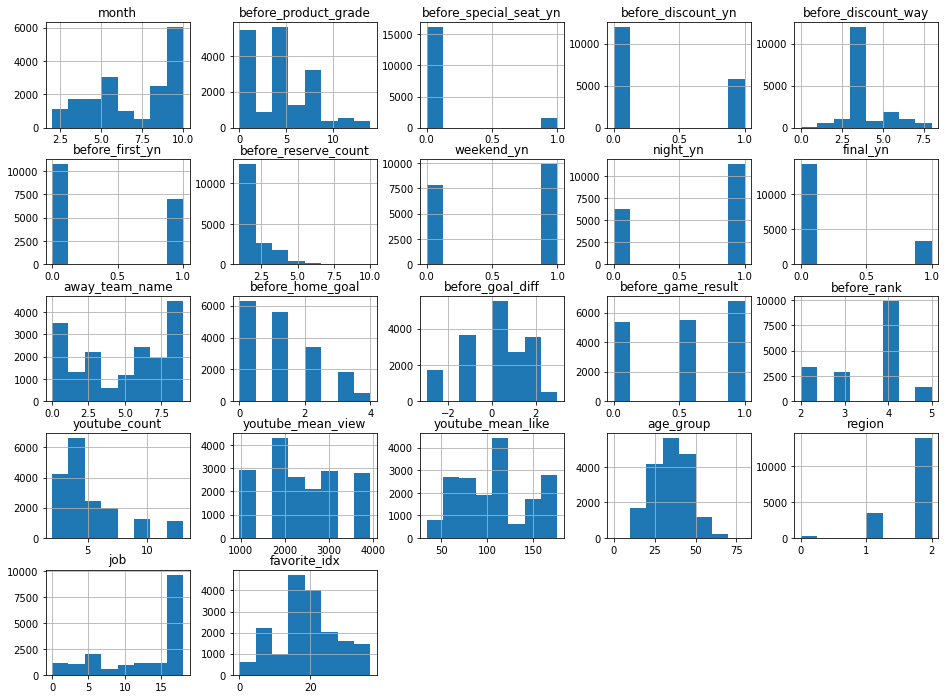

In [ ]:
X.hist(figsize=(16,12), bins=8)
plt.show()

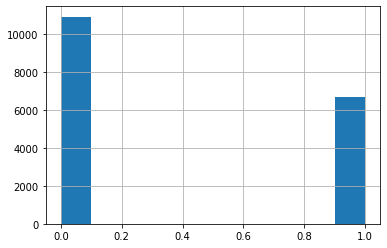

In [ ]:
y.hist()
plt.show()

In [ ]:
# 타겟이 다소 불균형함

# Feature Select

## 1. 직전 경기 결과 및 순위

In [ ]:
# 일부 피쳐 드랍
X1 = X.drop(['before_product_grade', 'before_special_seat_yn',
            'before_discount_yn', 'before_discount_way', 'before_first_yn', 'before_reserve_count',
            'youtube_count', 'youtube_mean_view', 'youtube_mean_like'], axis=1)

In [ ]:
X1.columns

Index(['month', 'weekend_yn', 'night_yn', 'final_yn', 'away_team_name',
       'before_home_goal', 'before_goal_diff', 'before_game_result',
       'before_rank', 'age_group', 'region', 'job', 'favorite_idx'],
      dtype='object')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=2, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2, stratify=y_train, shuffle=True)

In [ ]:
y_train.shape, y_val.shape, y_test.shape

((11300,), (2826,), (3532,))

In [ ]:
score_list1 = []

In [ ]:
rfc = RandomForestClassifier(random_state=2)

rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_val)
rfc_prob = rfc.predict_proba(X_val)[:,1]

score_list1.append(roc_auc_score(y_val, rfc_prob))

print('RandomForestClassifier')
print('roc_auc_score :', roc_auc_score(y_val, rfc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, rfc_pred))

RandomForestClassifier
roc_auc_score : 0.5740615993518654 

classification_report 
               precision    recall  f1-score   support

           0       0.66      0.72      0.69      1751
           1       0.46      0.39      0.42      1075

    accuracy                           0.59      2826
   macro avg       0.56      0.55      0.55      2826
weighted avg       0.58      0.59      0.59      2826



In [ ]:
xgc = XGBClassifier(random_state=42)

xgc.fit(X_train, y_train)

xgc_pred = xgc.predict(X_val)
xgc_prob = xgc.predict_proba(X_val)[:,1]

score_list1.append(roc_auc_score(y_val, xgc_prob))

print('XGBClassifier')
print('roc_auc_score :', roc_auc_score(y_val, xgc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, xgc_pred))

XGBClassifier
roc_auc_score : 0.656519995218679 

classification_report 
               precision    recall  f1-score   support

           0       0.66      0.86      0.75      1751
           1       0.55      0.28      0.37      1075

    accuracy                           0.64      2826
   macro avg       0.61      0.57      0.56      2826
weighted avg       0.62      0.64      0.60      2826



In [ ]:
lgc = LGBMClassifier(random_state=42)

lgc.fit(X_train, y_train)

lgc_pred = lgc.predict(X_val)
lgc_prob = lgc.predict_proba(X_val)[:,1]

score_list1.append(roc_auc_score(y_val, lgc_prob))

print('LGBMClassifier')
print('roc_auc_score :', roc_auc_score(y_val, lgc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, lgc_pred))

LGBMClassifier
roc_auc_score : 0.6678222411113914 

classification_report 
               precision    recall  f1-score   support

           0       0.67      0.83      0.74      1751
           1       0.55      0.34      0.42      1075

    accuracy                           0.64      2826
   macro avg       0.61      0.59      0.58      2826
weighted avg       0.63      0.64      0.62      2826



In [ ]:
print('RandomForestClassifier :', score_list1[0])
print('XGBClassifier :', score_list1[1])
print('LGBMClassifier :', score_list1[2])

RandomForestClassifier : 0.5740615993518654
XGBClassifier : 0.656519995218679
LGBMClassifier : 0.6678222411113914


## 2. 직전 경기 결과 및 순위 + 유튜브

In [ ]:
# 일부 피쳐 드랍
X2 = X.drop(['before_product_grade', 'before_special_seat_yn',
            'before_discount_yn', 'before_discount_way', 'before_first_yn', 'before_reserve_count'], axis=1)

In [ ]:
X2.columns

Index(['month', 'weekend_yn', 'night_yn', 'final_yn', 'away_team_name',
       'before_home_goal', 'before_goal_diff', 'before_game_result',
       'before_rank', 'youtube_count', 'youtube_mean_view',
       'youtube_mean_like', 'age_group', 'region', 'job', 'favorite_idx'],
      dtype='object')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=2, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2, stratify=y_train, shuffle=True)

In [ ]:
score_list2 = []

In [ ]:
rfc = RandomForestClassifier(random_state=2)

rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_val)
rfc_prob = rfc.predict_proba(X_val)[:,1]

score_list2.append(roc_auc_score(y_val, rfc_prob))

print('RandomForestClassifier')
print('roc_auc_score :', roc_auc_score(y_val, rfc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, rfc_pred))

RandomForestClassifier
roc_auc_score : 0.5769606736349993 

classification_report 
               precision    recall  f1-score   support

           0       0.66      0.72      0.69      1751
           1       0.46      0.38      0.42      1075

    accuracy                           0.59      2826
   macro avg       0.56      0.55      0.55      2826
weighted avg       0.58      0.59      0.59      2826



In [ ]:
xgc = XGBClassifier(random_state=2)

xgc.fit(X_train, y_train)

xgc_pred = xgc.predict(X_val)
xgc_prob = xgc.predict_proba(X_val)[:,1]

score_list2.append(roc_auc_score(y_val, xgc_prob))

print('XGBClassifier')
print('roc_auc_score :', roc_auc_score(y_val, xgc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, xgc_pred))

XGBClassifier
roc_auc_score : 0.6561680368692973 

classification_report 
               precision    recall  f1-score   support

           0       0.66      0.85      0.75      1751
           1       0.56      0.30      0.39      1075

    accuracy                           0.64      2826
   macro avg       0.61      0.58      0.57      2826
weighted avg       0.62      0.64      0.61      2826



In [ ]:
lgc = LGBMClassifier(random_state=2)

lgc.fit(X_train, y_train)

lgc_pred = lgc.predict(X_val)
lgc_prob = lgc.predict_proba(X_val)[:,1]

score_list2.append(roc_auc_score(y_val, lgc_prob))

print('LGBMClassifier')
print('roc_auc_score :', roc_auc_score(y_val, lgc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, lgc_pred))

LGBMClassifier
roc_auc_score : 0.6687522080405881 

classification_report 
               precision    recall  f1-score   support

           0       0.67      0.83      0.74      1751
           1       0.55      0.34      0.42      1075

    accuracy                           0.64      2826
   macro avg       0.61      0.59      0.58      2826
weighted avg       0.63      0.64      0.62      2826



In [ ]:
print('RandomForestClassifier :', score_list2[0])
print('XGBClassifier :', score_list2[1])
print('LGBMClassifier :', score_list2[2])

RandomForestClassifier : 0.5769606736349993
XGBClassifier : 0.6561680368692973
LGBMClassifier : 0.6687522080405881


## 3. 직전 경기 결과 및 순위 + 직전 예매 특성

In [ ]:
# 일부 피쳐 드랍
X3 = X.drop(['youtube_count', 'youtube_mean_view', 'youtube_mean_like'], axis=1)

In [ ]:
X3.columns

Index(['month', 'before_product_grade', 'before_special_seat_yn',
       'before_discount_yn', 'before_discount_way', 'before_first_yn',
       'before_reserve_count', 'weekend_yn', 'night_yn', 'final_yn',
       'away_team_name', 'before_home_goal', 'before_goal_diff',
       'before_game_result', 'before_rank', 'age_group', 'region', 'job',
       'favorite_idx'],
      dtype='object')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=2, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2, stratify=y_train, shuffle=True)

In [ ]:
score_list3 = []

In [ ]:
rfc = RandomForestClassifier(random_state=2)

rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_val)
rfc_prob = rfc.predict_proba(X_val)[:,1]

score_list3.append(roc_auc_score(y_val, rfc_prob))

print('RandomForestClassifier')
print('roc_auc_score :', roc_auc_score(y_val, rfc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, rfc_pred))

RandomForestClassifier
roc_auc_score : 0.7352723360737387 

classification_report 
               precision    recall  f1-score   support

           0       0.74      0.78      0.76      1751
           1       0.61      0.55      0.58      1075

    accuracy                           0.70      2826
   macro avg       0.68      0.67      0.67      2826
weighted avg       0.69      0.70      0.69      2826



In [ ]:
xgc = XGBClassifier(random_state=2)

xgc.fit(X_train, y_train)

xgc_pred = xgc.predict(X_val)
xgc_prob = xgc.predict_proba(X_val)[:,1]

score_list3.append(roc_auc_score(y_val, xgc_prob))

print('XGBClassifier')
print('roc_auc_score :', roc_auc_score(y_val, xgc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, xgc_pred))

XGBClassifier
roc_auc_score : 0.7827343843385175 

classification_report 
               precision    recall  f1-score   support

           0       0.75      0.81      0.78      1751
           1       0.65      0.57      0.61      1075

    accuracy                           0.72      2826
   macro avg       0.70      0.69      0.70      2826
weighted avg       0.72      0.72      0.72      2826



In [ ]:
lgc = LGBMClassifier(random_state=2)

lgc.fit(X_train, y_train)

lgc_pred = lgc.predict(X_val)
lgc_prob = lgc.predict_proba(X_val)[:,1]

score_list3.append(roc_auc_score(y_val, lgc_prob))

print('LGBMClassifier')
print('roc_auc_score :', roc_auc_score(y_val, lgc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, lgc_pred))

LGBMClassifier
roc_auc_score : 0.7813836611637205 

classification_report 
               precision    recall  f1-score   support

           0       0.76      0.82      0.79      1751
           1       0.67      0.57      0.61      1075

    accuracy                           0.73      2826
   macro avg       0.71      0.70      0.70      2826
weighted avg       0.72      0.73      0.72      2826



In [ ]:
print('RandomForestClassifier :', score_list3[0])
print('XGBClassifier :', score_list3[1])
print('LGBMClassifier :', score_list3[2])

RandomForestClassifier : 0.7352723360737387
XGBClassifier : 0.7827343843385175
LGBMClassifier : 0.7813836611637205


## 4. 직전 경기 결과 및 순위 + 직전 예매 특성 + 유튜브

In [ ]:
X4 = X.copy()

In [ ]:
X4.columns

Index(['month', 'before_product_grade', 'before_special_seat_yn',
       'before_discount_yn', 'before_discount_way', 'before_first_yn',
       'before_reserve_count', 'weekend_yn', 'night_yn', 'final_yn',
       'away_team_name', 'before_home_goal', 'before_goal_diff',
       'before_game_result', 'before_rank', 'youtube_count',
       'youtube_mean_view', 'youtube_mean_like', 'age_group', 'region', 'job',
       'favorite_idx'],
      dtype='object')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=2, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2, stratify=y_train, shuffle=True)

In [ ]:
score_list4 = []

In [ ]:
rfc = RandomForestClassifier(random_state=2)

rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_val)
rfc_prob = rfc.predict_proba(X_val)[:,1]

score_list4.append(roc_auc_score(y_val, rfc_prob))

print('RandomForestClassifier')
print('roc_auc_score :', roc_auc_score(y_val, rfc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, rfc_pred))

RandomForestClassifier
roc_auc_score : 0.7353929316138287 

classification_report 
               precision    recall  f1-score   support

           0       0.74      0.78      0.76      1751
           1       0.60      0.54      0.57      1075

    accuracy                           0.69      2826
   macro avg       0.67      0.66      0.66      2826
weighted avg       0.69      0.69      0.69      2826



In [ ]:
xgc = XGBClassifier(random_state=2)

xgc.fit(X_train, y_train)

xgc_pred = xgc.predict(X_val)
xgc_prob = xgc.predict_proba(X_val)[:,1]

score_list4.append(roc_auc_score(y_val, xgc_prob))

print('XGBClassifier')
print('roc_auc_score :', roc_auc_score(y_val, xgc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, xgc_pred))

XGBClassifier
roc_auc_score : 0.7848304623271751 

classification_report 
               precision    recall  f1-score   support

           0       0.76      0.82      0.79      1751
           1       0.66      0.57      0.61      1075

    accuracy                           0.72      2826
   macro avg       0.71      0.69      0.70      2826
weighted avg       0.72      0.72      0.72      2826



In [ ]:
lgc = LGBMClassifier(random_state=2)

lgc.fit(X_train, y_train)

lgc_pred = lgc.predict(X_val)
lgc_prob = lgc.predict_proba(X_val)[:,1]

score_list4.append(roc_auc_score(y_val, lgc_prob))

print('LGBMClassifier')
print('roc_auc_score :', roc_auc_score(y_val, lgc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, lgc_pred))

LGBMClassifier
roc_auc_score : 0.7807262295299696 

classification_report 
               precision    recall  f1-score   support

           0       0.76      0.81      0.78      1751
           1       0.65      0.57      0.61      1075

    accuracy                           0.72      2826
   macro avg       0.70      0.69      0.70      2826
weighted avg       0.72      0.72      0.72      2826



In [ ]:
print('RandomForestClassifier :', score_list4[0])
print('XGBClassifier :', score_list4[1])
print('LGBMClassifier :', score_list4[2])

RandomForestClassifier : 0.7353929316138287
XGBClassifier : 0.7848304623271751
LGBMClassifier : 0.7807262295299696


## 스코어 비교

In [ ]:
print(sum(score_list1)/3)
print(sum(score_list2)/3)
print(sum(score_list3)/3)
print(sum(score_list4)/3)

0.6328012785606453
0.6339603061816282
0.7664634605253257
0.7669832078236579


In [ ]:
print(score_list1)
print(score_list2)
print(score_list3)
print(score_list4)

[0.5740615993518654, 0.656519995218679, 0.6678222411113914]
[0.5769606736349993, 0.6561680368692973, 0.6687522080405881]
[0.7352723360737387, 0.7827343843385175, 0.7813836611637205]
[0.7353929316138287, 0.7848304623271751, 0.7807262295299696]


In [ ]:
# 모든 특성을 넣었을 때(X4), xgboost의 점수가 가장 높다.

# Hyper Parameter Tuning

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=2, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2, stratify=y_train, shuffle=True)

In [ ]:
def objective(trial):
  param = {
      "random_state" : 2,
      "objective" : "binary:logistic",
      "eval_metric" : "auc",
      "learning_rate" : trial.suggest_float("learning_rate", 0.01, 0.3),
      "n_estimators":trial.suggest_int("n_estimators", 100, 2000),
      "max_depth":trial.suggest_int("max_depth", 4, 10),
      "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
      "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 8.0),
      "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 1),
      "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 1),
      'subsample': trial.suggest_float('subsample', 0.5, 1.0),
  }

  xgc = XGBClassifier(**param)
  xgc.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_val,y_val)],
          early_stopping_rounds=100,
          verbose=100)
  xgc_prob = xgc.predict_proba(X_val)[:,1]
  roc_auc = roc_auc_score(y_val, xgc_prob)

  return roc_auc

sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name = 'xgc_parameter_opt',
    direction = 'maximize',
    sampler = sampler,
)
study.optimize(objective, n_trials=30)
print("Best Score:",study.best_value)
print("Best trial",study.best_trial.params)

[I 2023-02-14 20:18:31,922] A new study created in memory with name: xgc_parameter_opt


[0]	validation_0-auc:0.815223	validation_1-auc:0.744091
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.971072	validation_1-auc:0.763041
Stopping. Best iteration:
[39]	validation_0-auc:0.928899	validation_1-auc:0.77548



[I 2023-02-14 20:18:36,033] Trial 0 finished with value: 0.7754795266492237 and parameters: {'learning_rate': 0.11861663446573512, 'n_estimators': 1907, 'max_depth': 9, 'colsample_bytree': 0.759195090518222, 'scale_pos_weight': 2.0921304830970557, 'reg_lambda': 0.16443457513284063, 'reg_alpha': 0.06750277604651747, 'subsample': 0.9330880728874675}. Best is trial 0 with value: 0.7754795266492237.


[0]	validation_0-auc:0.75238	validation_1-auc:0.753267
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.833693	validation_1-auc:0.777385
Stopping. Best iteration:
[30]	validation_0-auc:0.803049	validation_1-auc:0.781566



[I 2023-02-14 20:18:38,455] Trial 1 finished with value: 0.781566148247513 and parameters: {'learning_rate': 0.18432335340553055, 'n_estimators': 1446, 'max_depth': 4, 'colsample_bytree': 0.9819459112971965, 'scale_pos_weight': 6.827098485602952, 'reg_lambda': 0.2202157195714934, 'reg_alpha': 0.19000671753502962, 'subsample': 0.5917022549267169}. Best is trial 1 with value: 0.781566148247513.


[0]	validation_0-auc:0.778345	validation_1-auc:0.756454
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.891212	validation_1-auc:0.773683
Stopping. Best iteration:
[45]	validation_0-auc:0.855433	validation_1-auc:0.781757



[I 2023-02-14 20:18:42,131] Trial 2 finished with value: 0.7817571354574795 and parameters: {'learning_rate': 0.09823025045826593, 'n_estimators': 1097, 'max_depth': 7, 'colsample_bytree': 0.5747374841188252, 'scale_pos_weight': 5.282970263056656, 'reg_lambda': 0.14809892204552141, 'reg_alpha': 0.29922320204986597, 'subsample': 0.6831809216468459}. Best is trial 2 with value: 0.7817571354574795.


[0]	validation_0-auc:0.761099	validation_1-auc:0.755384
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.851937	validation_1-auc:0.774434
Stopping. Best iteration:
[39]	validation_0-auc:0.818311	validation_1-auc:0.781841



[I 2023-02-14 20:18:45,352] Trial 3 finished with value: 0.7818413398323881 and parameters: {'learning_rate': 0.1422602954229404, 'n_estimators': 1592, 'max_depth': 5, 'colsample_bytree': 0.708540663048167, 'scale_pos_weight': 5.146901982034297, 'reg_lambda': 0.05598590859279775, 'reg_alpha': 0.611469403382424, 'subsample': 0.5852620618436457}. Best is trial 3 with value: 0.7818413398323881.


[0]	validation_0-auc:0.808236	validation_1-auc:0.736565
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.928877	validation_1-auc:0.777326
Stopping. Best iteration:
[84]	validation_0-auc:0.922129	validation_1-auc:0.777943



[I 2023-02-14 20:18:52,976] Trial 4 finished with value: 0.7779435007238389 and parameters: {'learning_rate': 0.02886496196573106, 'n_estimators': 1903, 'max_depth': 10, 'colsample_bytree': 0.8850384088698766, 'scale_pos_weight': 3.132296384213595, 'reg_lambda': 0.10669539286632003, 'reg_alpha': 0.6873906962470353, 'subsample': 0.7200762468698007}. Best is trial 3 with value: 0.7818413398323881.


[0]	validation_0-auc:0.753369	validation_1-auc:0.753636
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.800393	validation_1-auc:0.784514
[200]	validation_0-auc:0.816924	validation_1-auc:0.784611
Stopping. Best iteration:
[172]	validation_0-auc:0.813046	validation_1-auc:0.785455



[I 2023-02-14 20:18:58,494] Trial 5 finished with value: 0.7854546903430597 and parameters: {'learning_rate': 0.045391088104985856, 'n_estimators': 1041, 'max_depth': 4, 'colsample_bytree': 0.9455922412472693, 'scale_pos_weight': 2.8114598712001184, 'reg_lambda': 0.6658970615104421, 'reg_alpha': 0.31859396532851686, 'subsample': 0.7600340105889054}. Best is trial 5 with value: 0.7854546903430597.


[0]	validation_0-auc:0.797869	validation_1-auc:0.750499
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.99293	validation_1-auc:0.753487
Stopping. Best iteration:
[13]	validation_0-auc:0.90152	validation_1-auc:0.768756



[I 2023-02-14 20:19:02,576] Trial 6 finished with value: 0.768756192474732 and parameters: {'learning_rate': 0.1685459810095511, 'n_estimators': 451, 'max_depth': 10, 'colsample_bytree': 0.8650796940166687, 'scale_pos_weight': 7.576492590949324, 'reg_lambda': 0.8958790769233723, 'reg_alpha': 0.6019209790229743, 'subsample': 0.9609371175115584}. Best is trial 5 with value: 0.7854546903430597.


[0]	validation_0-auc:0.753222	validation_1-auc:0.754751
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.794704	validation_1-auc:0.782434
[200]	validation_0-auc:0.808108	validation_1-auc:0.783603
Stopping. Best iteration:
[156]	validation_0-auc:0.803042	validation_1-auc:0.784027



[I 2023-02-14 20:19:06,409] Trial 7 finished with value: 0.7840266691458702 and parameters: {'learning_rate': 0.03566282559505665, 'n_estimators': 472, 'max_depth': 4, 'colsample_bytree': 0.5951981984579586, 'scale_pos_weight': 3.720741027826374, 'reg_lambda': 0.27863554145615693, 'reg_alpha': 0.83045013406041, 'subsample': 0.6783766633467947}. Best is trial 5 with value: 0.7854546903430597.


[0]	validation_0-auc:0.753483	validation_1-auc:0.752986
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.813804	validation_1-auc:0.782693
Stopping. Best iteration:
[89]	validation_0-auc:0.810668	validation_1-auc:0.783468



[I 2023-02-14 20:19:10,642] Trial 8 finished with value: 0.7834675202210033 and parameters: {'learning_rate': 0.09147100780934041, 'n_estimators': 1131, 'max_depth': 4, 'colsample_bytree': 0.8813181884524238, 'scale_pos_weight': 1.5218545057583959, 'reg_lambda': 0.9870180672345121, 'reg_alpha': 0.7745223216036908, 'subsample': 0.5993578407670862}. Best is trial 5 with value: 0.7854546903430597.


[0]	validation_0-auc:0.779991	validation_1-auc:0.740632
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.84944	validation_1-auc:0.779489
[200]	validation_0-auc:0.865652	validation_1-auc:0.779872
[300]	validation_0-auc:0.883318	validation_1-auc:0.780946
Stopping. Best iteration:
[246]	validation_0-auc:0.874	validation_1-auc:0.781465



[I 2023-02-14 20:19:22,985] Trial 9 finished with value: 0.7814652092491998 and parameters: {'learning_rate': 0.011601413965844696, 'n_estimators': 1650, 'max_depth': 8, 'colsample_bytree': 0.8374043008245924, 'scale_pos_weight': 6.39889242680162, 'reg_lambda': 0.08330420521674946, 'reg_alpha': 0.3648810712588299, 'subsample': 0.5579345297625649}. Best is trial 5 with value: 0.7854546903430597.


[0]	validation_0-auc:0.759902	validation_1-auc:0.748269
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.885229	validation_1-auc:0.777613
[110]	validation_0-auc:0.891216	validation_1-auc:0.774568


[I 2023-02-14 20:19:24,874] Trial 10 finished with value: 0.78645026762116 and parameters: {'learning_rate': 0.24951473255123494, 'n_estimators': 111, 'max_depth': 6, 'colsample_bytree': 0.4107771253688918, 'scale_pos_weight': 1.1442417906638007, 'reg_lambda': 0.618747251591657, 'reg_alpha': 0.9601730384859655, 'subsample': 0.8189858776055303}. Best is trial 10 with value: 0.78645026762116.


[0]	validation_0-auc:0.759971	validation_1-auc:0.747266
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.888771	validation_1-auc:0.778489
[111]	validation_0-auc:0.894983	validation_1-auc:0.775899


[I 2023-02-14 20:19:26,802] Trial 11 finished with value: 0.7874859548696427 and parameters: {'learning_rate': 0.2629666610293458, 'n_estimators': 112, 'max_depth': 6, 'colsample_bytree': 0.4103116901613753, 'scale_pos_weight': 1.2337620298655758, 'reg_lambda': 0.6426879190555743, 'reg_alpha': 0.9584254848816028, 'subsample': 0.8179189248615294}. Best is trial 11 with value: 0.7874859548696427.


[0]	validation_0-auc:0.757374	validation_1-auc:0.749859
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.885363	validation_1-auc:0.770988
[113]	validation_0-auc:0.891653	validation_1-auc:0.76749


[I 2023-02-14 20:19:28,676] Trial 12 finished with value: 0.7856225678349914 and parameters: {'learning_rate': 0.2651625157582131, 'n_estimators': 114, 'max_depth': 6, 'colsample_bytree': 0.4021844471848666, 'scale_pos_weight': 1.3202294079087247, 'reg_lambda': 0.5325011040997317, 'reg_alpha': 0.994778362686775, 'subsample': 0.8384090290478075}. Best is trial 11 with value: 0.7874859548696427.


[0]	validation_0-auc:0.758266	validation_1-auc:0.747913
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.892736	validation_1-auc:0.770461
Stopping. Best iteration:
[17]	validation_0-auc:0.824113	validation_1-auc:0.784688



[I 2023-02-14 20:19:30,605] Trial 13 finished with value: 0.7846880852137649 and parameters: {'learning_rate': 0.29623358732372906, 'n_estimators': 163, 'max_depth': 6, 'colsample_bytree': 0.40608548256244703, 'scale_pos_weight': 2.1984272893432584, 'reg_lambda': 0.7012164315858042, 'reg_alpha': 0.9993688142551356, 'subsample': 0.839379936111606}. Best is trial 11 with value: 0.7874859548696427.


[0]	validation_0-auc:0.7606	validation_1-auc:0.748534
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.890296	validation_1-auc:0.773301
Stopping. Best iteration:
[18]	validation_0-auc:0.822966	validation_1-auc:0.784061



[I 2023-02-14 20:19:32,694] Trial 14 finished with value: 0.7840614665373938 and parameters: {'learning_rate': 0.22788362690694497, 'n_estimators': 559, 'max_depth': 6, 'colsample_bytree': 0.4865277182478581, 'scale_pos_weight': 1.091982210024657, 'reg_lambda': 0.40211430469156656, 'reg_alpha': 0.8555842294841385, 'subsample': 0.8230693516111118}. Best is trial 11 with value: 0.7874859548696427.


[0]	validation_0-auc:0.766542	validation_1-auc:0.742095
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.925606	validation_1-auc:0.7688
Stopping. Best iteration:
[19]	validation_0-auc:0.845029	validation_1-auc:0.780604



[I 2023-02-14 20:19:36,012] Trial 15 finished with value: 0.7806037745872789 and parameters: {'learning_rate': 0.22348340130437788, 'n_estimators': 654, 'max_depth': 7, 'colsample_bytree': 0.49933376883122665, 'scale_pos_weight': 3.655927848583586, 'reg_lambda': 0.5708692448463317, 'reg_alpha': 0.8828722635583831, 'subsample': 0.8973226820560444}. Best is trial 11 with value: 0.7874859548696427.


[0]	validation_0-auc:0.786539	validation_1-auc:0.752151
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.964859	validation_1-auc:0.748256
Stopping. Best iteration:
[6]	validation_0-auc:0.829158	validation_1-auc:0.777077



[I 2023-02-14 20:19:38,806] Trial 16 finished with value: 0.7770770191120026 and parameters: {'learning_rate': 0.2841225255897722, 'n_estimators': 803, 'max_depth': 8, 'colsample_bytree': 0.6046350230731545, 'scale_pos_weight': 1.0207759180295466, 'reg_lambda': 0.7289052529282566, 'reg_alpha': 0.5044773910471319, 'subsample': 0.7763585633553955}. Best is trial 11 with value: 0.7874859548696427.


[0]	validation_0-auc:0.756412	validation_1-auc:0.750727
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.86624	validation_1-auc:0.775085
Stopping. Best iteration:
[18]	validation_0-auc:0.809493	validation_1-auc:0.78486



[I 2023-02-14 20:19:40,513] Trial 17 finished with value: 0.7848599471398403 and parameters: {'learning_rate': 0.253466388149991, 'n_estimators': 289, 'max_depth': 5, 'colsample_bytree': 0.471682702224907, 'scale_pos_weight': 2.3001986005705906, 'reg_lambda': 0.3948815028385223, 'reg_alpha': 0.9286200941657455, 'subsample': 0.9769712260839398}. Best is trial 11 with value: 0.7874859548696427.


[0]	validation_0-auc:0.77891	validation_1-auc:0.761844
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.938422	validation_1-auc:0.760223
Stopping. Best iteration:
[15]	validation_0-auc:0.841387	validation_1-auc:0.779618



[I 2023-02-14 20:19:42,940] Trial 18 finished with value: 0.7796177599511243 and parameters: {'learning_rate': 0.2519833587321405, 'n_estimators': 331, 'max_depth': 7, 'colsample_bytree': 0.5530956993235534, 'scale_pos_weight': 1.8370749696638002, 'reg_lambda': 0.8158537685220534, 'reg_alpha': 0.7356907104860719, 'subsample': 0.8853253753576177}. Best is trial 11 with value: 0.7874859548696427.


[0]	validation_0-auc:0.76165	validation_1-auc:0.756065
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.869766	validation_1-auc:0.776885
Stopping. Best iteration:
[32]	validation_0-auc:0.825059	validation_1-auc:0.784229



[I 2023-02-14 20:19:45,233] Trial 19 finished with value: 0.7842293440293253 and parameters: {'learning_rate': 0.21336109317523866, 'n_estimators': 816, 'max_depth': 5, 'colsample_bytree': 0.6491371737276597, 'scale_pos_weight': 2.713253737600193, 'reg_lambda': 0.5956024942857684, 'reg_alpha': 0.8022262926489931, 'subsample': 0.8008082749384638}. Best is trial 11 with value: 0.7874859548696427.


[0]	validation_0-auc:0.773806	validation_1-auc:0.743775
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.934945	validation_1-auc:0.771389
[106]	validation_0-auc:0.938664	validation_1-auc:0.770014


[I 2023-02-14 20:19:48,287] Trial 20 finished with value: 0.784635225054122 and parameters: {'learning_rate': 0.19943914726123319, 'n_estimators': 107, 'max_depth': 8, 'colsample_bytree': 0.44594470377757633, 'scale_pos_weight': 1.7713466449217532, 'reg_lambda': 0.47461122103554443, 'reg_alpha': 0.9121779781026393, 'subsample': 0.8630496716721736}. Best is trial 11 with value: 0.7874859548696427.


[0]	validation_0-auc:0.757194	validation_1-auc:0.749498
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.886015	validation_1-auc:0.77275
Stopping. Best iteration:
[11]	validation_0-auc:0.808231	validation_1-auc:0.785596



[I 2023-02-14 20:19:50,390] Trial 21 finished with value: 0.7855960049406984 and parameters: {'learning_rate': 0.2642143574176719, 'n_estimators': 306, 'max_depth': 6, 'colsample_bytree': 0.4015007353168187, 'scale_pos_weight': 1.2487094581955727, 'reg_lambda': 0.5690830985058186, 'reg_alpha': 0.9992268213442868, 'subsample': 0.8157476467963456}. Best is trial 11 with value: 0.7874859548696427.


[0]	validation_0-auc:0.761469	validation_1-auc:0.750893
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.899092	validation_1-auc:0.769204
Stopping. Best iteration:
[20]	validation_0-auc:0.830703	validation_1-auc:0.785164



[I 2023-02-14 20:19:52,568] Trial 22 finished with value: 0.7851638266505518 and parameters: {'learning_rate': 0.2775954774134863, 'n_estimators': 122, 'max_depth': 6, 'colsample_bytree': 0.5170141948808076, 'scale_pos_weight': 1.0820653002679423, 'reg_lambda': 0.47557657934730435, 'reg_alpha': 0.9902568390895674, 'subsample': 0.8556765563588324}. Best is trial 11 with value: 0.7874859548696427.


[0]	validation_0-auc:0.756792	validation_1-auc:0.749026
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.857672	validation_1-auc:0.77607
Stopping. Best iteration:
[19]	validation_0-auc:0.808324	validation_1-auc:0.785302



[I 2023-02-14 20:19:54,281] Trial 23 finished with value: 0.7853024849587611 and parameters: {'learning_rate': 0.242633888117353, 'n_estimators': 345, 'max_depth': 5, 'colsample_bytree': 0.43285187884105913, 'scale_pos_weight': 1.7155177801015578, 'reg_lambda': 0.6401559280120314, 'reg_alpha': 0.887375146038076, 'subsample': 0.9028604319253704}. Best is trial 11 with value: 0.7874859548696427.


[0]	validation_0-auc:0.765635	validation_1-auc:0.742737
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.930729	validation_1-auc:0.761987
Stopping. Best iteration:
[17]	validation_0-auc:0.844112	validation_1-auc:0.781457



[I 2023-02-14 20:19:57,585] Trial 24 finished with value: 0.781456709123026 and parameters: {'learning_rate': 0.2967536464789028, 'n_estimators': 664, 'max_depth': 7, 'colsample_bytree': 0.44870125495726204, 'scale_pos_weight': 2.436786523707778, 'reg_lambda': 0.7554445963193909, 'reg_alpha': 0.7974145779010076, 'subsample': 0.7847736143162334}. Best is trial 11 with value: 0.7874859548696427.


[0]	validation_0-auc:0.759523	validation_1-auc:0.750003
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.887813	validation_1-auc:0.775125
Stopping. Best iteration:
[17]	validation_0-auc:0.822754	validation_1-auc:0.786687



[I 2023-02-14 20:20:00,731] Trial 25 finished with value: 0.7866872086382534 and parameters: {'learning_rate': 0.2680075920752224, 'n_estimators': 216, 'max_depth': 6, 'colsample_bytree': 0.40108218760751363, 'scale_pos_weight': 1.6250489492879157, 'reg_lambda': 0.5409028975228712, 'reg_alpha': 0.9157223773767211, 'subsample': 0.9997067470438427}. Best is trial 11 with value: 0.7874859548696427.


[0]	validation_0-auc:0.757267	validation_1-auc:0.74961
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.862135	validation_1-auc:0.778879
Stopping. Best iteration:
[26]	validation_0-auc:0.815555	validation_1-auc:0.786729



[I 2023-02-14 20:20:03,023] Trial 26 finished with value: 0.786729178011236 and parameters: {'learning_rate': 0.22495423121308897, 'n_estimators': 284, 'max_depth': 5, 'colsample_bytree': 0.5341224725527756, 'scale_pos_weight': 1.9001956556013622, 'reg_lambda': 0.6364805469799987, 'reg_alpha': 0.920407277303527, 'subsample': 0.9991375618947643}. Best is trial 11 with value: 0.7874859548696427.


[0]	validation_0-auc:0.756288	validation_1-auc:0.75141
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.86365	validation_1-auc:0.776779
Stopping. Best iteration:
[19]	validation_0-auc:0.809711	validation_1-auc:0.786086



[I 2023-02-14 20:20:04,766] Trial 27 finished with value: 0.7860858247114606 and parameters: {'learning_rate': 0.2331903325733085, 'n_estimators': 472, 'max_depth': 5, 'colsample_bytree': 0.5235057597126582, 'scale_pos_weight': 1.9212000527098079, 'reg_lambda': 0.7823198600955171, 'reg_alpha': 0.8763903166551755, 'subsample': 0.9972176218232742}. Best is trial 11 with value: 0.7874859548696427.


[0]	validation_0-auc:0.756357	validation_1-auc:0.75023
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.855414	validation_1-auc:0.777587
Stopping. Best iteration:
[19]	validation_0-auc:0.806569	validation_1-auc:0.785866



[I 2023-02-14 20:20:06,554] Trial 28 finished with value: 0.785865618317772 and parameters: {'learning_rate': 0.20432896847284482, 'n_estimators': 921, 'max_depth': 5, 'colsample_bytree': 0.4782451386645202, 'scale_pos_weight': 3.037144356661152, 'reg_lambda': 0.6730282852573511, 'reg_alpha': 0.9192253754513794, 'subsample': 0.9340493465153249}. Best is trial 11 with value: 0.7874859548696427.


[0]	validation_0-auc:0.768477	validation_1-auc:0.748725
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.940141	validation_1-auc:0.763509
Stopping. Best iteration:
[16]	validation_0-auc:0.845383	validation_1-auc:0.78362



[I 2023-02-14 20:20:08,890] Trial 29 finished with value: 0.7836197256053019 and parameters: {'learning_rate': 0.2668762241324181, 'n_estimators': 271, 'max_depth': 7, 'colsample_bytree': 0.5356632512861519, 'scale_pos_weight': 2.182560343520512, 'reg_lambda': 0.6341780680917745, 'reg_alpha': 0.7394325094379888, 'subsample': 0.9471128917266103}. Best is trial 11 with value: 0.7874859548696427.


Best Score: 0.7874859548696427
Best trial {'learning_rate': 0.2629666610293458, 'n_estimators': 112, 'max_depth': 6, 'colsample_bytree': 0.4103116901613753, 'scale_pos_weight': 1.2337620298655758, 'reg_lambda': 0.6426879190555743, 'reg_alpha': 0.9584254848816028, 'subsample': 0.8179189248615294}


In [ ]:
params = study.best_params

params["random_state"] = 2
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'auc'

In [ ]:
xgc = XGBClassifier(**params)

xgc.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val,y_val)],
        early_stopping_rounds=100,
        verbose=100)

[0]	validation_0-auc:0.759971	validation_1-auc:0.747266
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.888771	validation_1-auc:0.778489
[111]	validation_0-auc:0.894983	validation_1-auc:0.775899


XGBClassifier(colsample_bytree=0.4103116901613753, eval_metric='auc',
              learning_rate=0.2629666610293458, max_depth=6, n_estimators=112,
              random_state=2, reg_alpha=0.9584254848816028,
              reg_lambda=0.6426879190555743,
              scale_pos_weight=1.2337620298655758,
              subsample=0.8179189248615294)

In [ ]:
xgc_pred = xgc.predict(X_val)
xgc_prob = xgc.predict_proba(X_val)[:,1]

print('XGBClassifier_val')
print('roc_auc_score :', roc_auc_score(y_val, xgc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, xgc_pred))

XGBClassifier_val
roc_auc_score : 0.7874859548696427 

classification_report 
               precision    recall  f1-score   support

           0       0.78      0.77      0.77      1751
           1       0.63      0.65      0.64      1075

    accuracy                           0.72      2826
   macro avg       0.71      0.71      0.71      2826
weighted avg       0.72      0.72      0.72      2826



In [ ]:
xgc_pred = xgc.predict(X_test)
xgc_prob = xgc.predict_proba(X_test)[:,1]

print('XGBClassifier_test')
print('roc_auc_score :', roc_auc_score(y_test, xgc_prob), '\n')
print('classification_report', '\n', classification_report(y_test, xgc_pred))

XGBClassifier_test
roc_auc_score : 0.7776729264603465 

classification_report 
               precision    recall  f1-score   support

           0       0.78      0.76      0.77      2188
           1       0.63      0.66      0.64      1344

    accuracy                           0.72      3532
   macro avg       0.70      0.71      0.71      3532
weighted avg       0.72      0.72      0.72      3532



In [ ]:
feature_importance = pd.DataFrame([X_test.columns, xgc.feature_importances_]).T.rename(columns={0:'features',1:'importance'}).sort_values('importance', ascending=False).reset_index(drop=True)

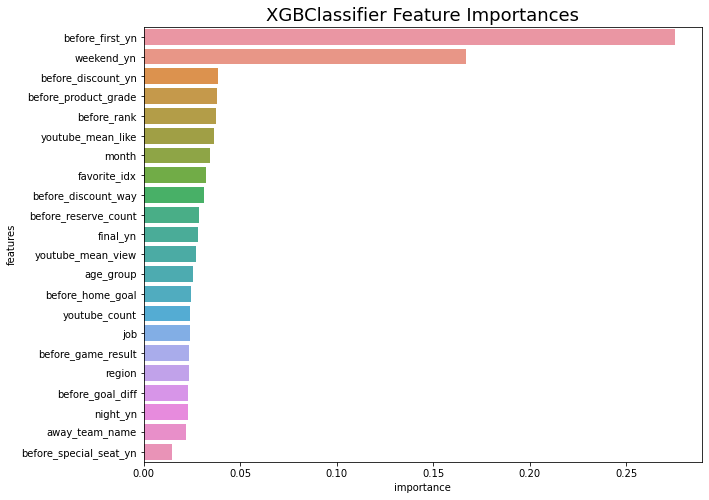

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='features', data=feature_importance)
plt.title('XGBClassifier Feature Importances', fontsize=18)
plt.show()

In [ ]:
df[['MB_IDX','date']] = raw[['MB_IDX','date']]

In [ ]:
df.head()

,date,MB_IDX,before_product_grade,before_special_seat_yn,before_discount_yn,before_discount_way,before_first_yn,before_reserve_count,weekend_yn,night_yn,...,total_special_seat,total_reserve_date,total_reserve_ticket,rate_ticket_discount,rate_special_seat,mean_reserve_ticket,mean_game_nth_diff,last_game_nth,cluster,target
0,2022-02-26,122611,Exciting석,0,0,없음,1,1,1,0,...,0,5,9,0.11,0.00,1.80,3.75,16,3,1
1,2022-02-26,134139,Exciting석,0,0,없음,1,1,1,0,...,0,8,18,0.50,0.00,2.25,2.57,19,3,1
2,2022-02-26,136924,Exciting석,0,0,없음,1,1,1,0,...,0,9,13,0.00,0.00,1.44,2.00,17,3,1
3,2022-03-05,119758,Exciting석,0,0,없음,1,2,1,1,...,0,2,4,0.00,0.00,2.00,1.00,3,3,1
4,2022-03-05,132795,Exciting석,0,0,없음,1,3,1,1,...,6,4,13,0.00,0.46,3.25,5.67,19,2,1


In [ ]:
df.to_csv('data_analysis.csv', index=False)